# read TCGA_COAD data

In [1]:
#### read TCGA_COAD data ####
COAD_UCSC_Toil_tpm_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/UCSC_Toil/COAD_UCSC_Toil_tpm_dataset.rds")
COAD_RSEM_gene_tpm <- COAD_UCSC_Toil_tpm_dataset$COAD.RSEM.gene.tpm
gencode.v23.annotation <- COAD_UCSC_Toil_tpm_dataset$gencode.v23.annotation
COAD.pheno <- COAD_UCSC_Toil_tpm_dataset$COAD.pheno
#head(gencode.v23.annotation)
## convert ensembleID to symbol 
geneMatch <- match(rownames(COAD_RSEM_gene_tpm),gencode.v23.annotation$V1)
geneSymbol <- as.character(gencode.v23.annotation[geneMatch,]$V2)
COAD_tpm_symbol <- COAD_RSEM_gene_tpm
rownames(COAD_tpm_symbol) <- geneSymbol
#head(COAD_tpm_symbol)

### Phenotype Update
### Seperate the Normal and Tumor samples
sampleID<- as.character(COAD.pheno$sample)
table(unlist(lapply(strsplit(sampleID,"-"), '[[', 4)))
sampleTypes <- unlist(lapply(strsplit(sampleID,"-"), '[[', 4))
sampleTypes[sampleTypes=="01"]<- "Tumor"
sampleTypes[sampleTypes=="11"]<- "Nomal"
COAD.pheno <- cbind(COAD.pheno , sampleTypes)


 01  02  06  11 
286   1   1  41 

In [2]:
## Read log10(x+1) transformed scReference 

scReference.log10.CV <- readRDS("/data8t_4/JH/MyJobs/Normal_cell_reference/Step2_Merge_and_Filter_the_scReference/2020_1_19_scReferenceV4.log10.CV.rds")
scReference.list.log10 <- scReference.log10.CV$scReference.list.log10
scReference.list.log10.CV1000 <- scReference.log10.CV$scReference.list.log10.CV1000
scReference.list.log10.CV1500 <- scReference.log10.CV$scReference.list.log10.CV1500
scReference.list.log10.CV2000 <- scReference.log10.CV$scReference.list.log10.CV2000
scReference.list.log10.CV4000 <- scReference.log10.CV$scReference.list.log10.CV4000
scReference.list.log10.CV8000 <- scReference.log10.CV$scReference.list.log10.CV8000

In [3]:
### Distance calculation
##### Distance calculation 
source("/data8t_4/JH/MyJobs/1_R_script/NormalCancer/refCorMerge.R")
### 
##### Transform COAD data
summary(colSums(COAD_tpm_symbol)) ### So its not log2 transformed
# Expression data transformation Log(x+1)
Log10.expList <- list(COAD_tpm_symbol = log10(COAD_tpm_symbol+1))
Cor.Res.CV8000 <- refCorMerge(Log10.expList, scReference.list.log10.CV1000)
Cor.Res.CV4000 <- refCorMerge(Log10.expList, scReference.list.log10.CV1500)
Cor.Res.CV2000 <- refCorMerge(Log10.expList, scReference.list.log10.CV2000)
Cor.Res.CV1500 <- refCorMerge(Log10.expList, scReference.list.log10.CV4000)
Cor.Res.CV1000 <- refCorMerge(Log10.expList, scReference.list.log10.CV8000)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1e+06   1e+06   1e+06   1e+06   1e+06   1e+06 

[1] "Using 10 parallel cores"
[1] "Using 10 parallel cores"
[1] "Using 10 parallel cores"
[1] "Using 10 parallel cores"
[1] "Using 10 parallel cores"


In [4]:
#### Raw Correlation value transformed into correlation percent for each cell
########## Convert cor value to rang From 1 to 0 max was 1 min was 0
#Trans.Rang1<- base::apply(Cor.Res$Cor.merged, 2, function(x){
#  (x-min(x))/(max(x)-min(x))
#})
Trans.Rang1.1000<- base::apply(Cor.Res.CV1000$Cor.merged, 2, function(x){
  (x-min(x))/(max(x)-min(x))
})
Trans.Rang1.1500<- base::apply(Cor.Res.CV1500$Cor.merged, 2, function(x){
  (x-min(x))/(max(x)-min(x))
})
Trans.Rang1.2000<- base::apply(Cor.Res.CV2000$Cor.merged, 2, function(x){
  (x-min(x))/(max(x)-min(x))
})
Trans.Rang1.4000<- base::apply(Cor.Res.CV4000$Cor.merged, 2, function(x){
  (x-min(x))/(max(x)-min(x))
})
Trans.Rang1.8000<- base::apply(Cor.Res.CV8000$Cor.merged, 2, function(x){
  (x-min(x))/(max(x)-min(x))
})

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

Calculating consensus matrix...
Loading required package: pheatmap


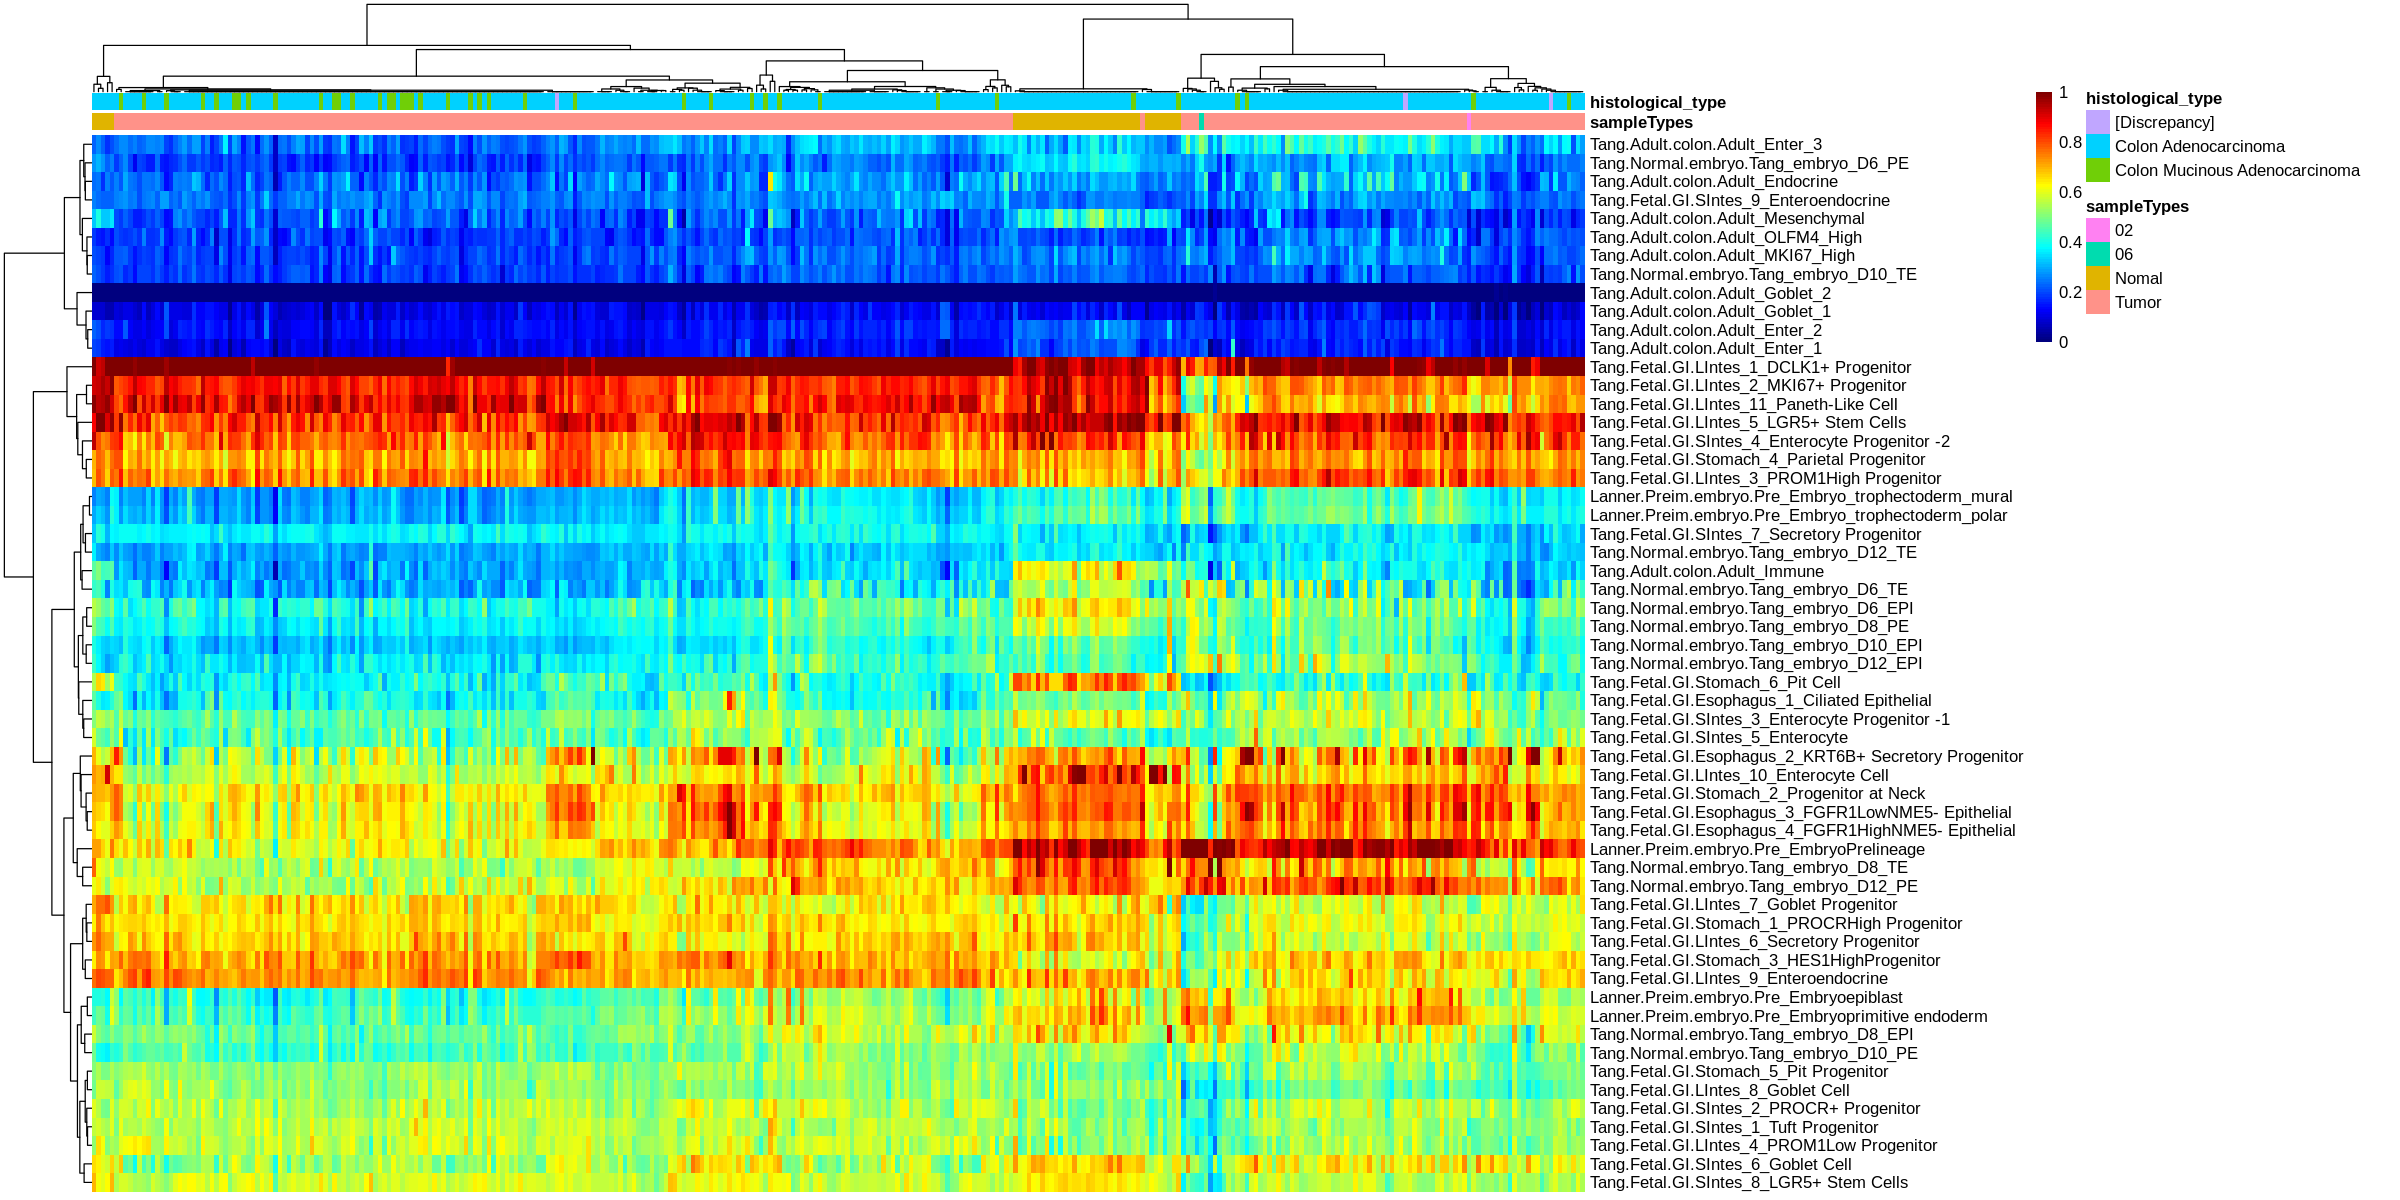

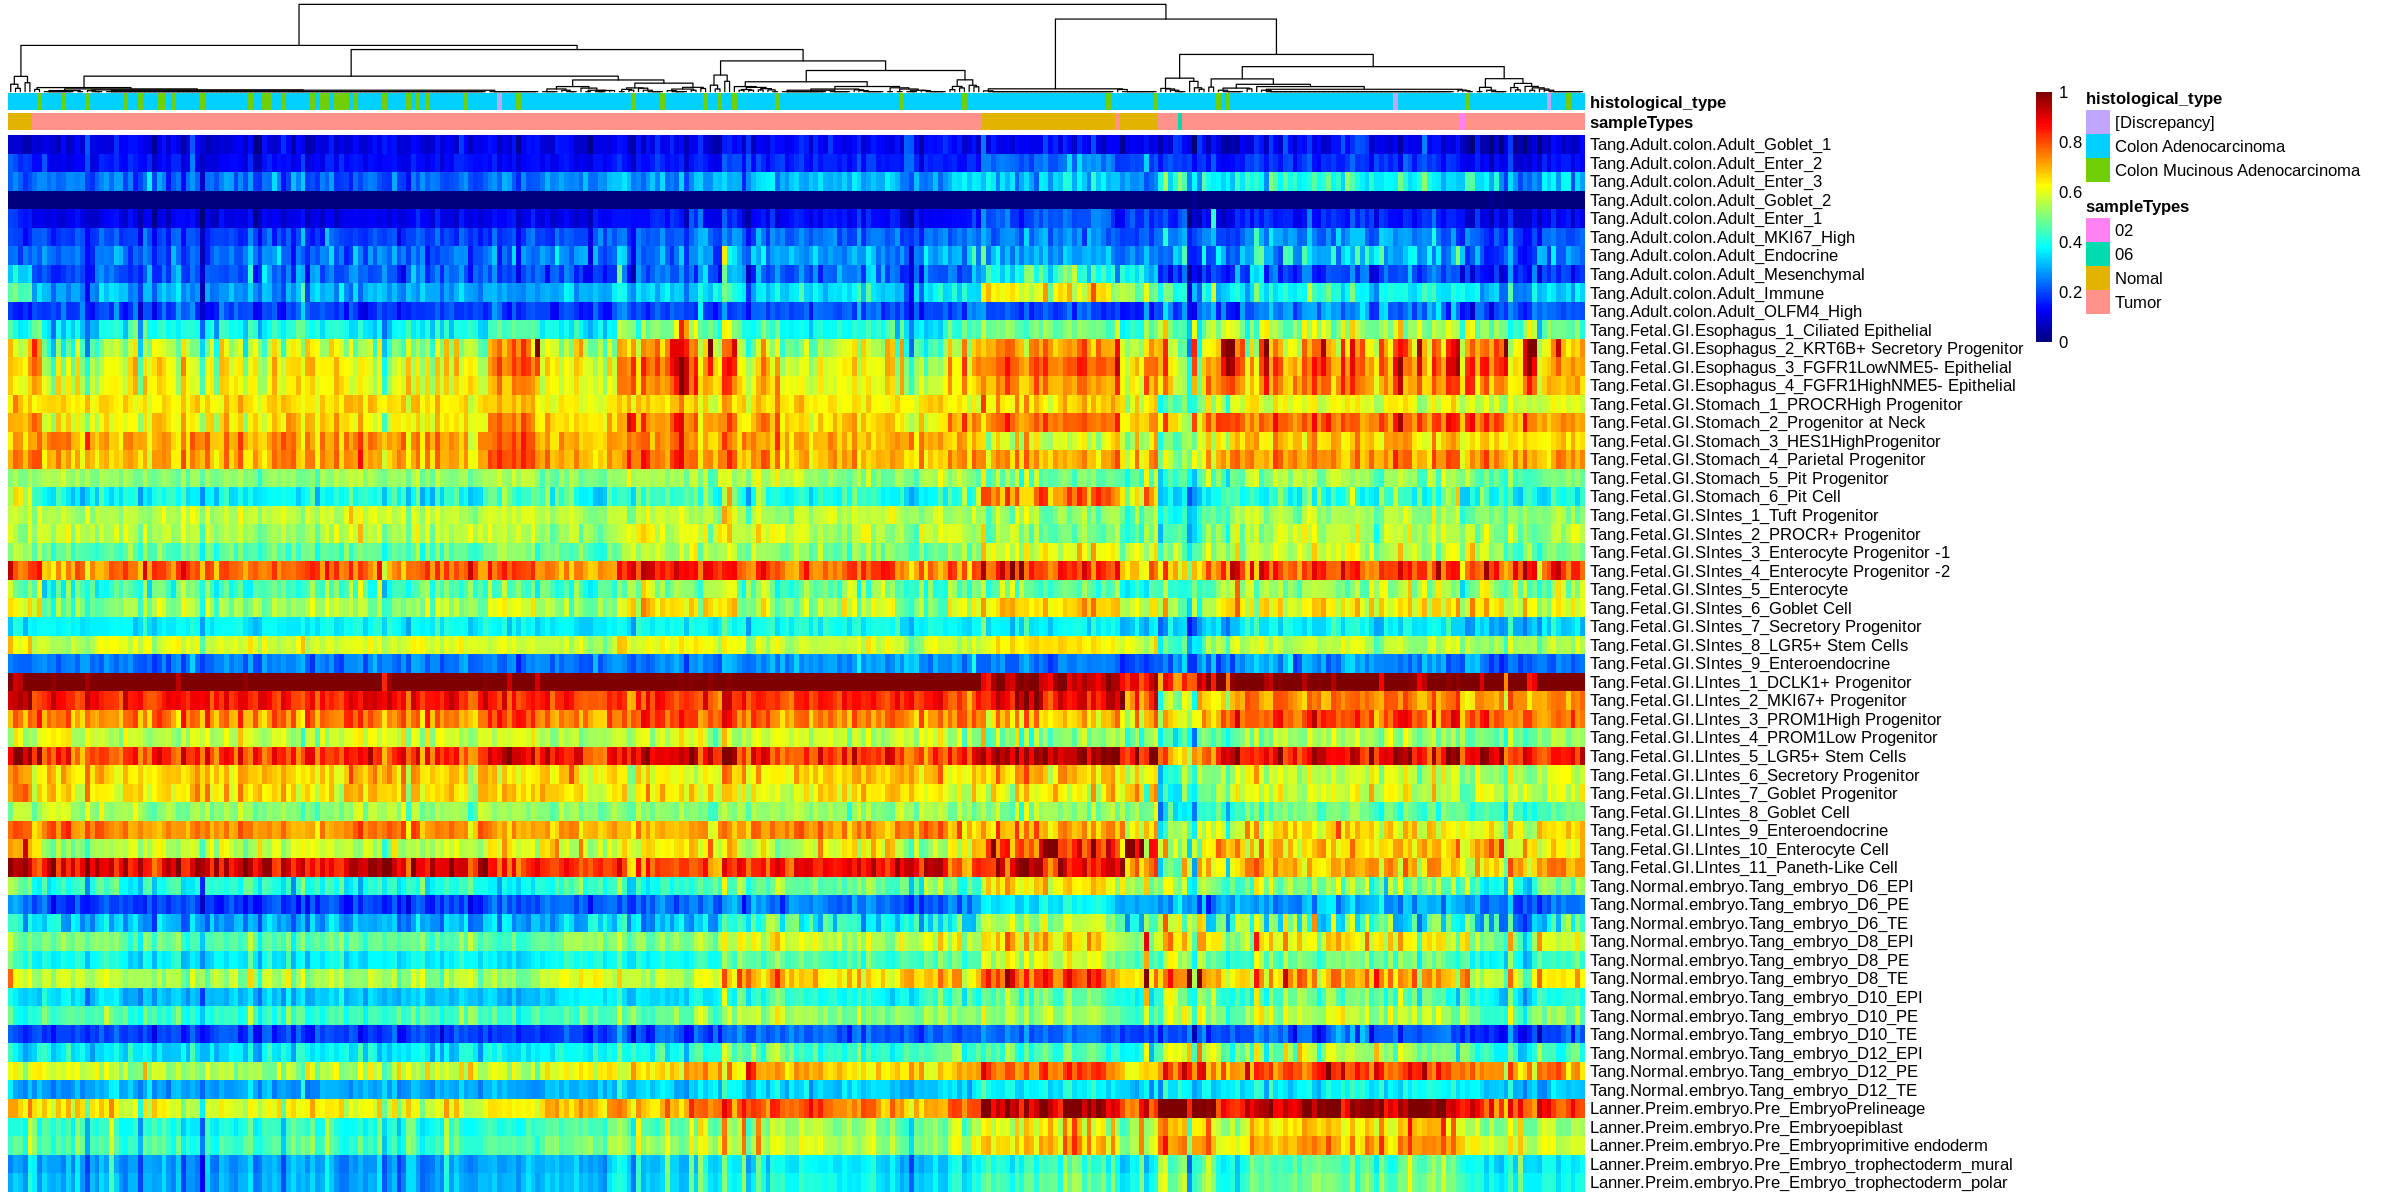

In [5]:
## cv8000 
source("/data8t_4/JH/MyJobs/1_R_script/NormalCancer/JH_SC3_cluster.R")
Cor.tumor <- Trans.Rang1.8000
Pheno.merged.tumor <- COAD.pheno[,c("sampleTypes","histological_type")]
### Step3.Cluster cells (In my script the cells with 0 variance was removed)
SC3.Tumor <- JH_SC3_cluster(Cor.tumor,Pheno.merged.tumor,ks=2:4)
## Select a cluster results
hcTumor <- SC3.Tumor$`3`$hc
## Check cluster result
source("/data8t_4/JH/MyJobs/1_R_script/R_Plot/heatmap.JH.R")
options(repr.plot.width=20, repr.plot.height=10)
heatmap.JH(Cor.tumor,show_colnames = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor)
heatmap.JH(Cor.tumor,show_colnames = F,cluster_rows = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor)

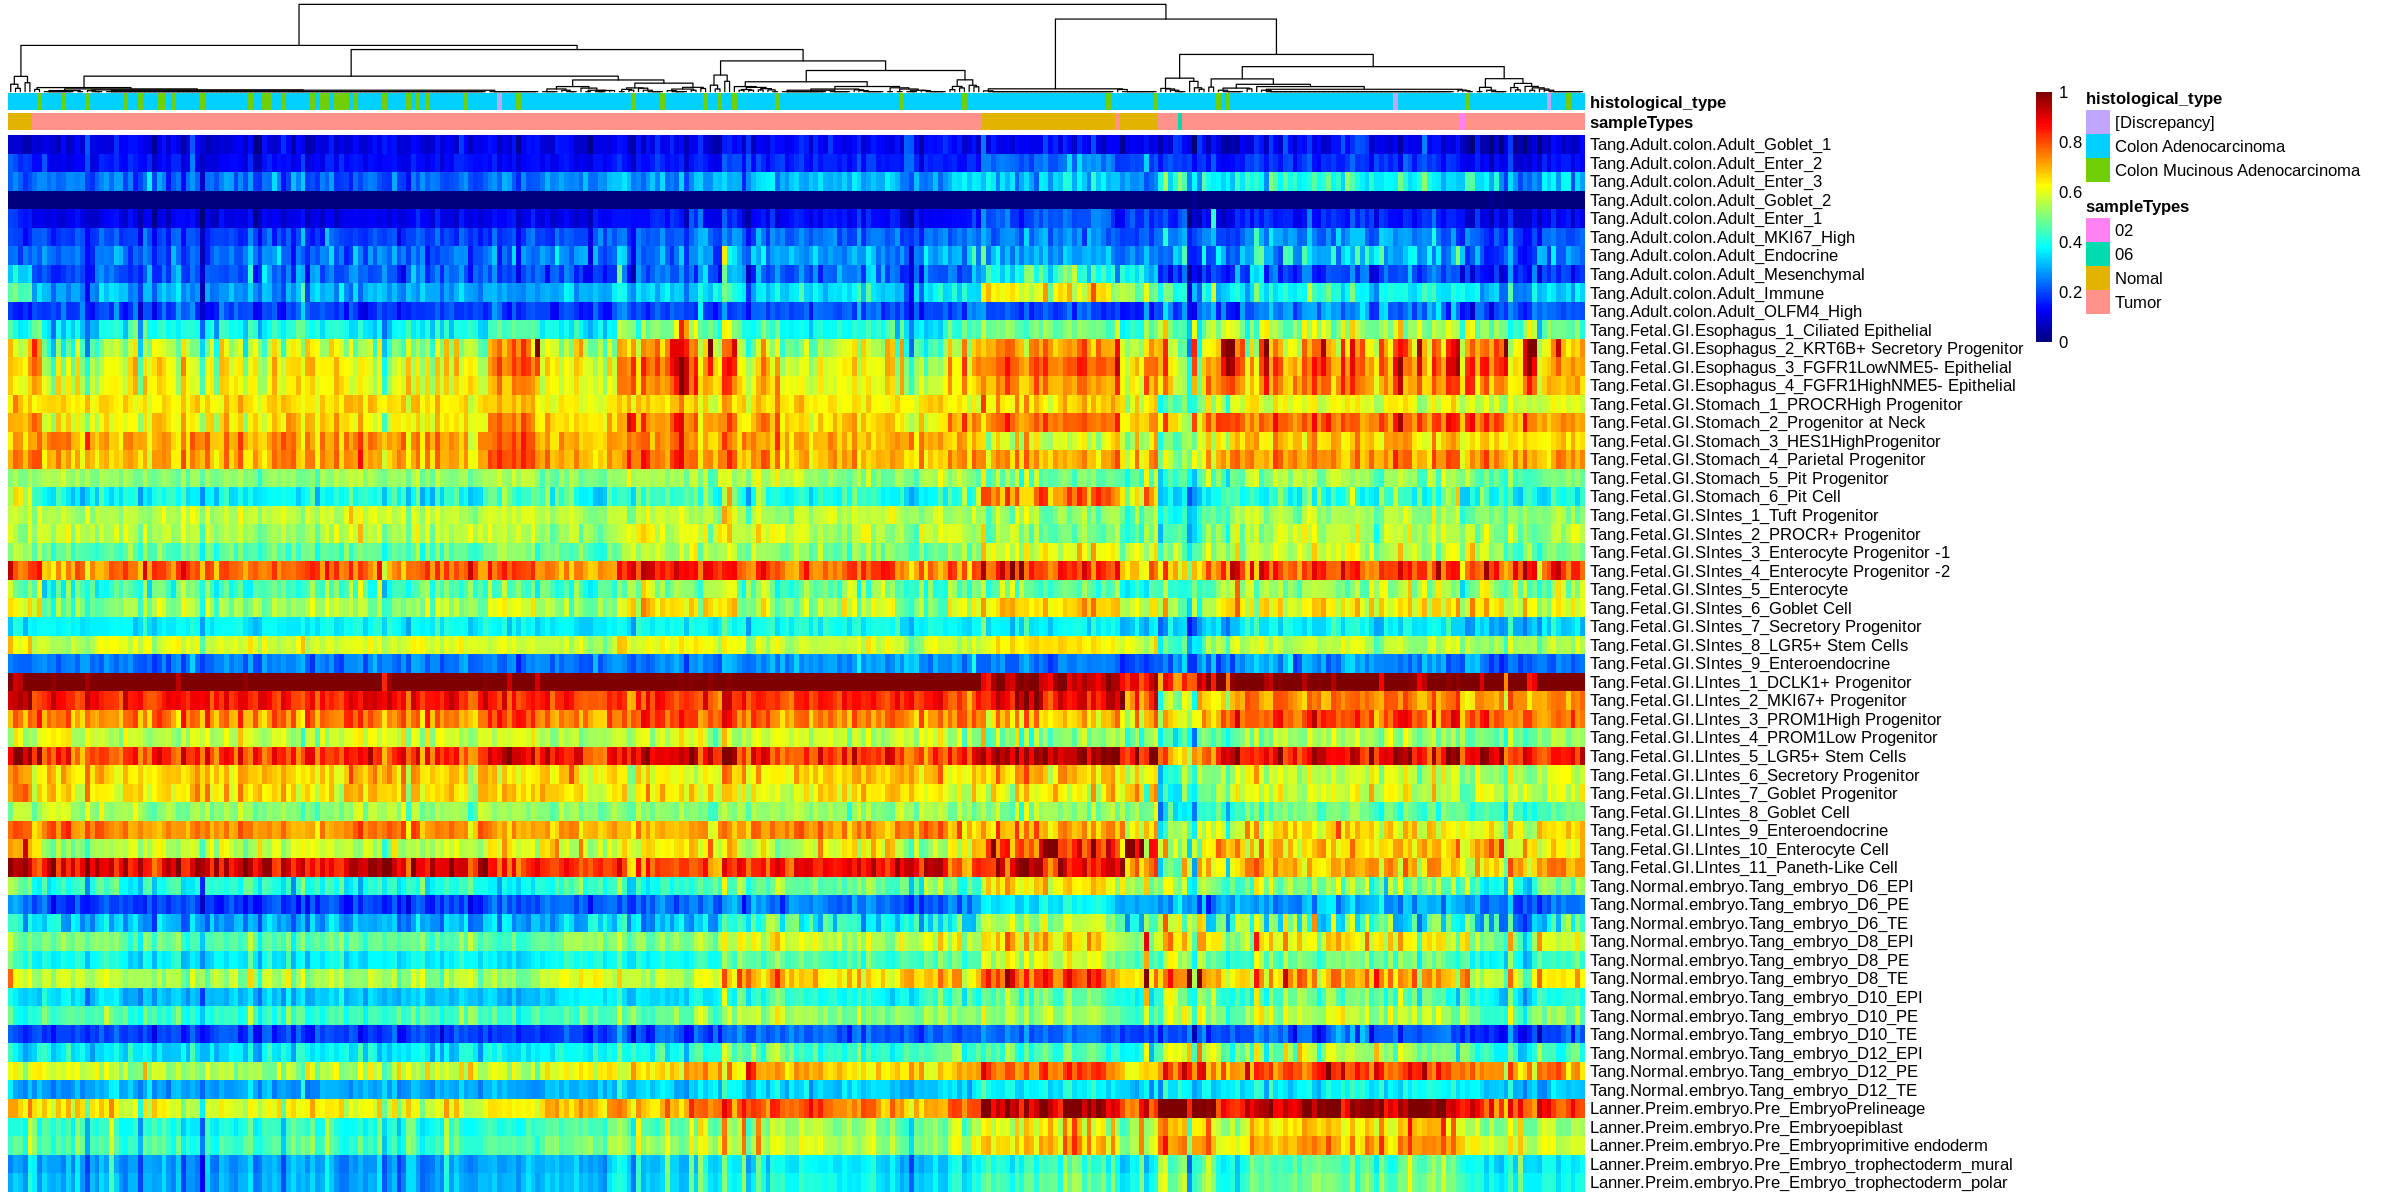

In [6]:
hcTumor.8000 <- hcTumor
heatmap.JH(Cor.tumor,show_colnames = F,cluster_rows = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor.8000)

Setting SC3 parameters...
Calculating distances between the cells...
Performing transformations and calculating eigenvectors...
Performing k-means clustering...


Calculating consensus matrix...


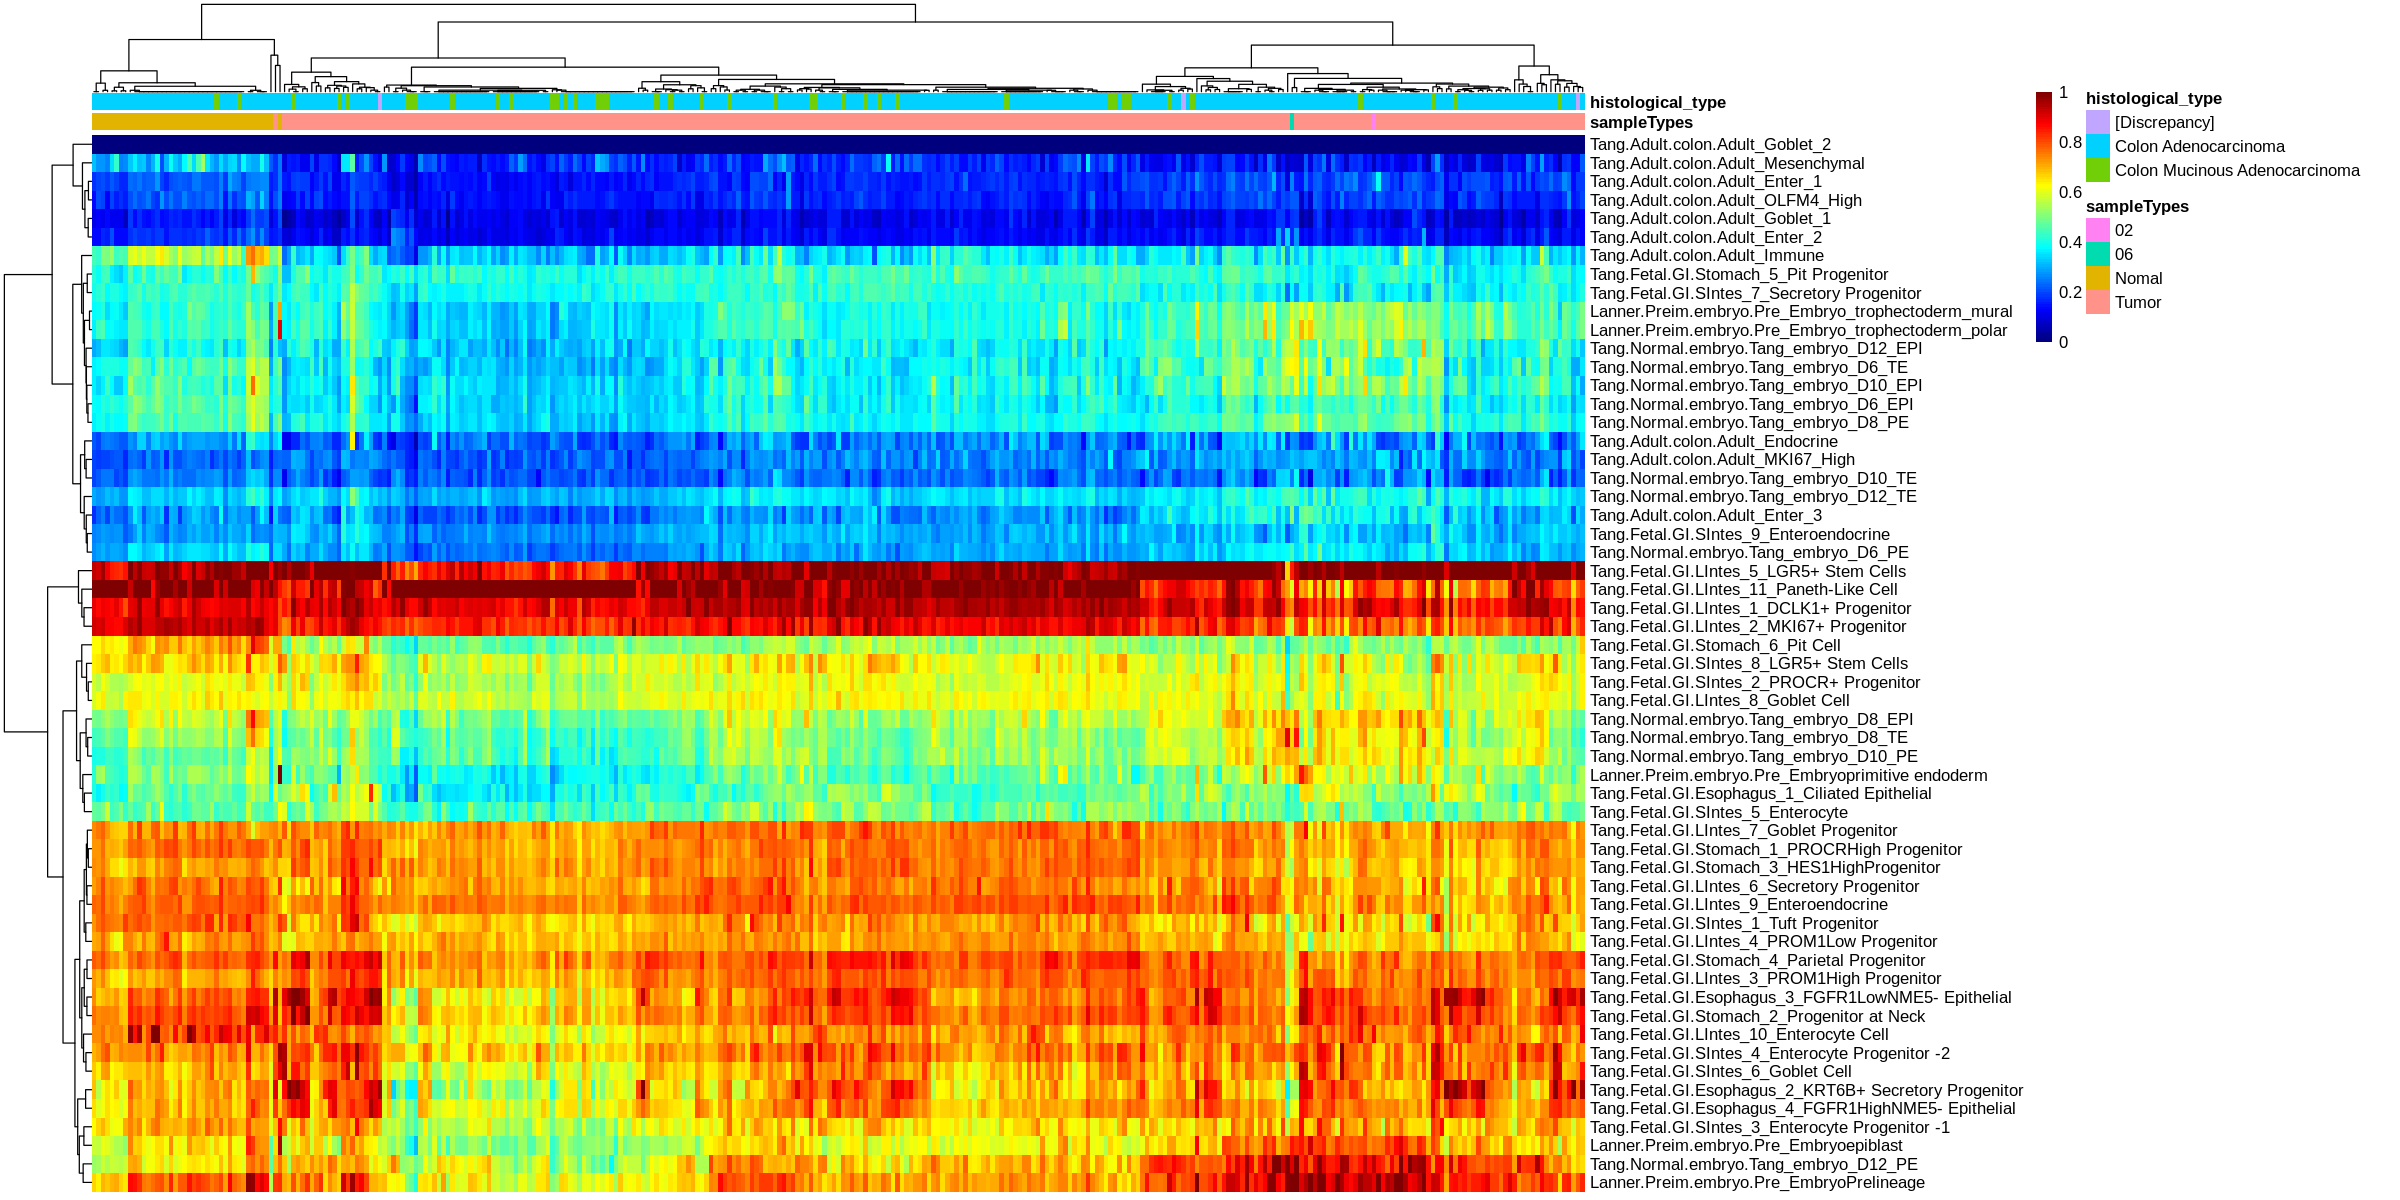

In [7]:
## cv4000 
source("/data8t_4/JH/MyJobs/1_R_script/NormalCancer/JH_SC3_cluster.R")
Cor.tumor <- Trans.Rang1.4000
Pheno.merged.tumor <- COAD.pheno[,c("sampleTypes","histological_type")]
### Step3.Cluster cells (In my script the cells with 0 variance was removed)
SC3.Tumor <- JH_SC3_cluster(Cor.tumor,Pheno.merged.tumor,ks=2:4)
## Select a cluster results
hcTumor <- SC3.Tumor$`3`$hc
## Check cluster result
source("/data8t_4/JH/MyJobs/1_R_script/R_Plot/heatmap.JH.R")
options(repr.plot.width=20, repr.plot.height=10)
heatmap.JH(Cor.tumor,show_colnames = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor)

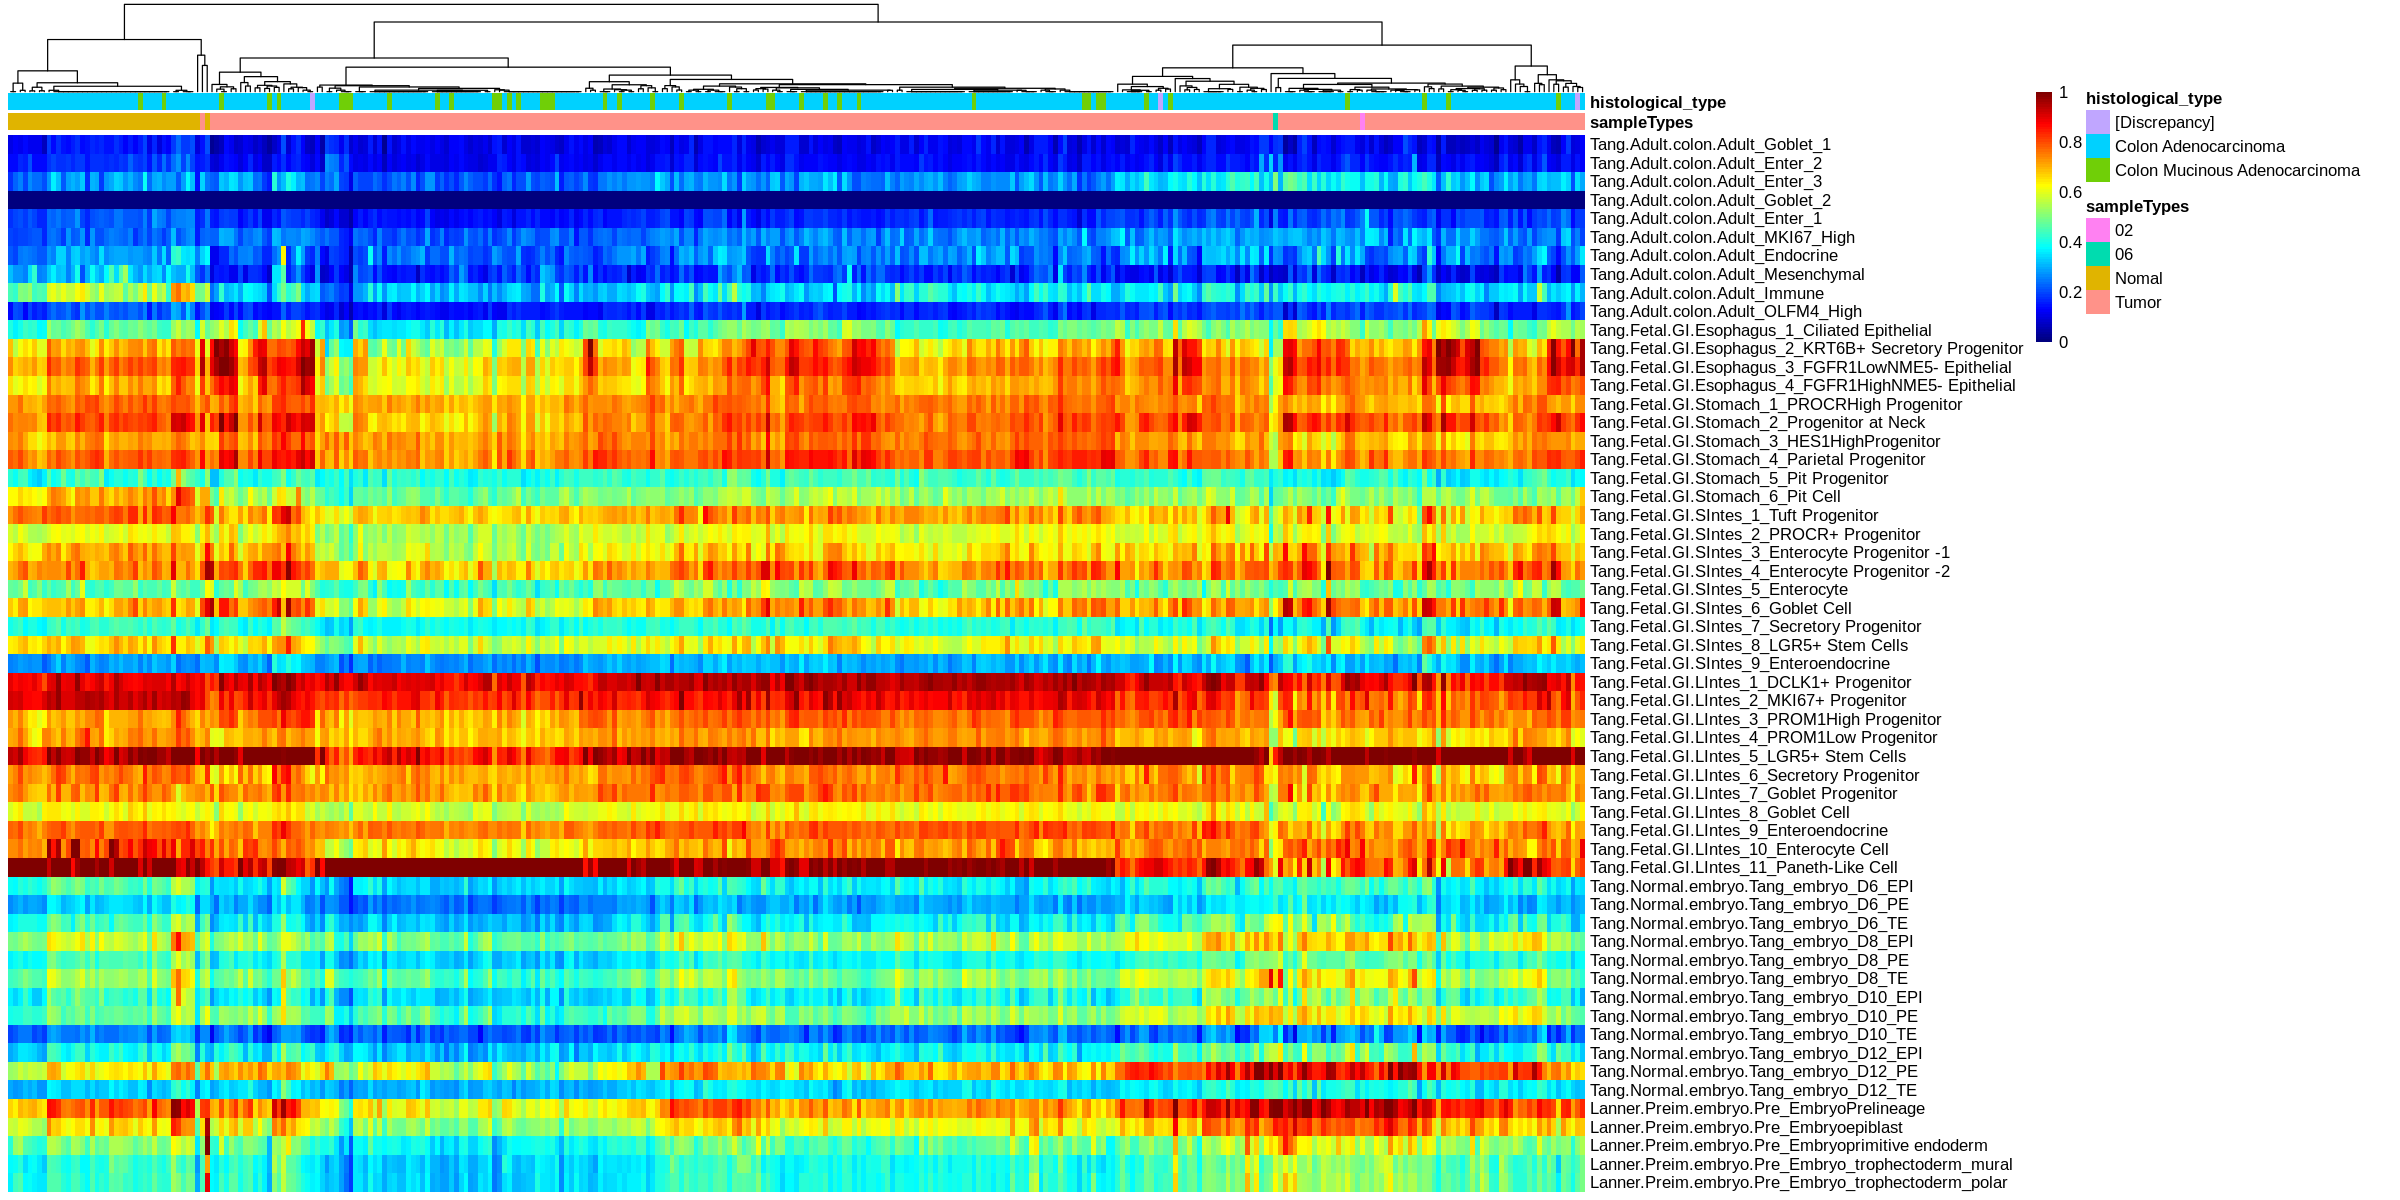

In [8]:
hcTumor.4000 <- hcTumor
heatmap.JH(Cor.tumor,show_colnames = F,cluster_rows = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor.4000)

Setting SC3 parameters...
Calculating distances between the cells...
Performing transformations and calculating eigenvectors...
Performing k-means clustering...


Calculating consensus matrix...


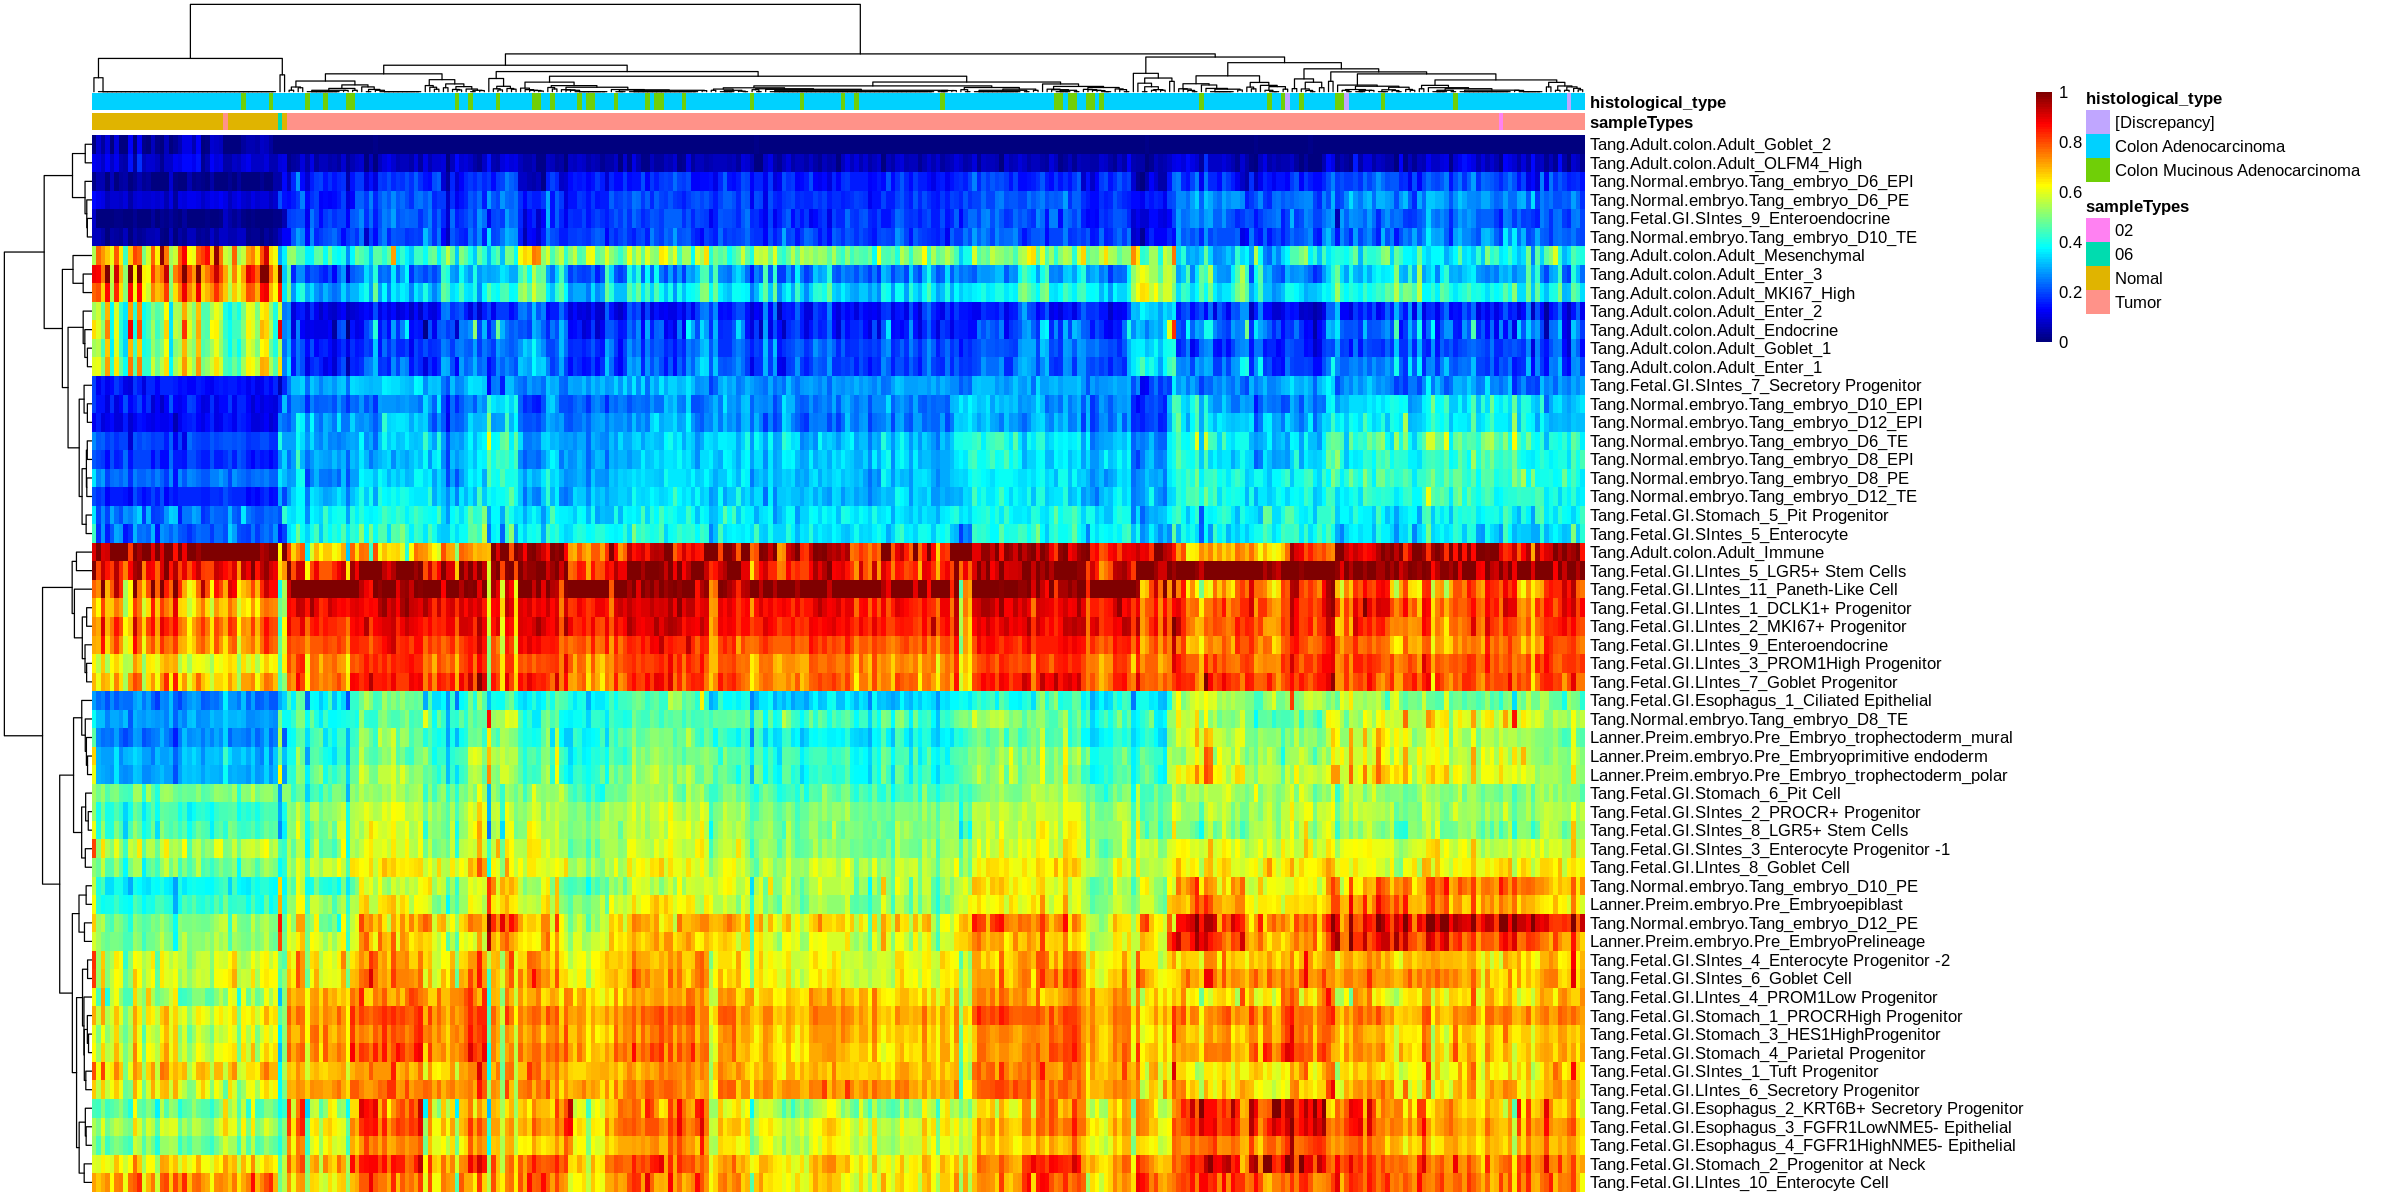

In [9]:
## cv2000 
source("/data8t_4/JH/MyJobs/1_R_script/NormalCancer/JH_SC3_cluster.R")
Cor.tumor <- Trans.Rang1.2000
Pheno.merged.tumor <- COAD.pheno[,c("sampleTypes","histological_type")]
### Step3.Cluster cells (In my script the cells with 0 variance was removed)
SC3.Tumor <- JH_SC3_cluster(Cor.tumor,Pheno.merged.tumor,ks=2:4)
## Select a cluster results
hcTumor <- SC3.Tumor$`3`$hc
## Check cluster result
source("/data8t_4/JH/MyJobs/1_R_script/R_Plot/heatmap.JH.R")
options(repr.plot.width=20, repr.plot.height=10)
heatmap.JH(Cor.tumor,show_colnames = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor)

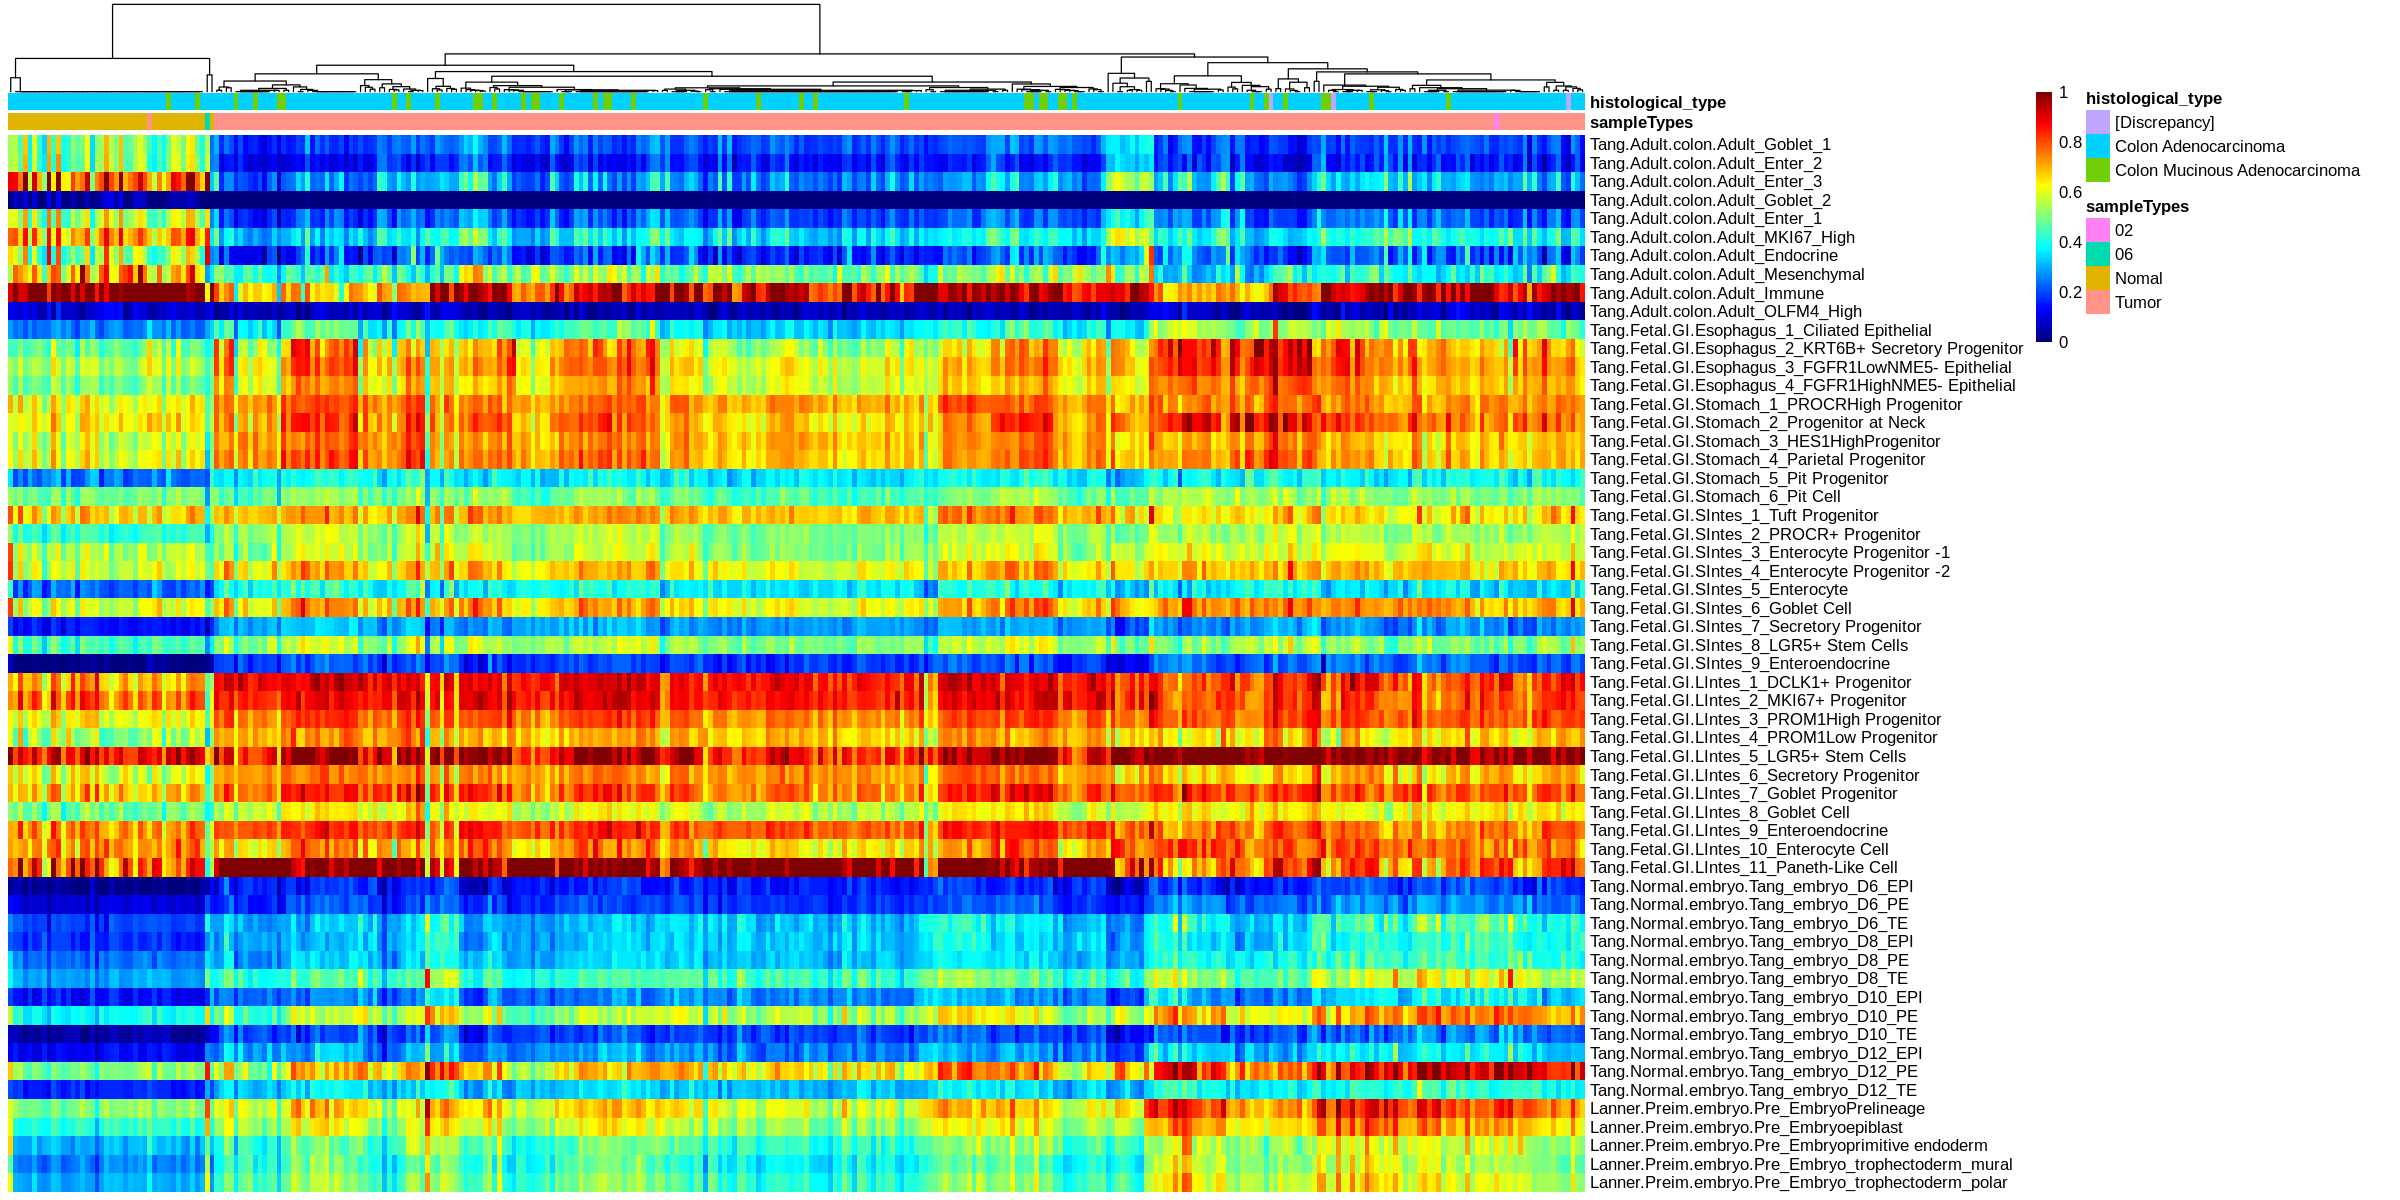

In [10]:
hcTumor.2000 <- hcTumor
heatmap.JH(Cor.tumor,show_colnames = F,cluster_rows = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor.2000)

Setting SC3 parameters...
Calculating distances between the cells...
Performing transformations and calculating eigenvectors...
Performing k-means clustering...


Calculating consensus matrix...


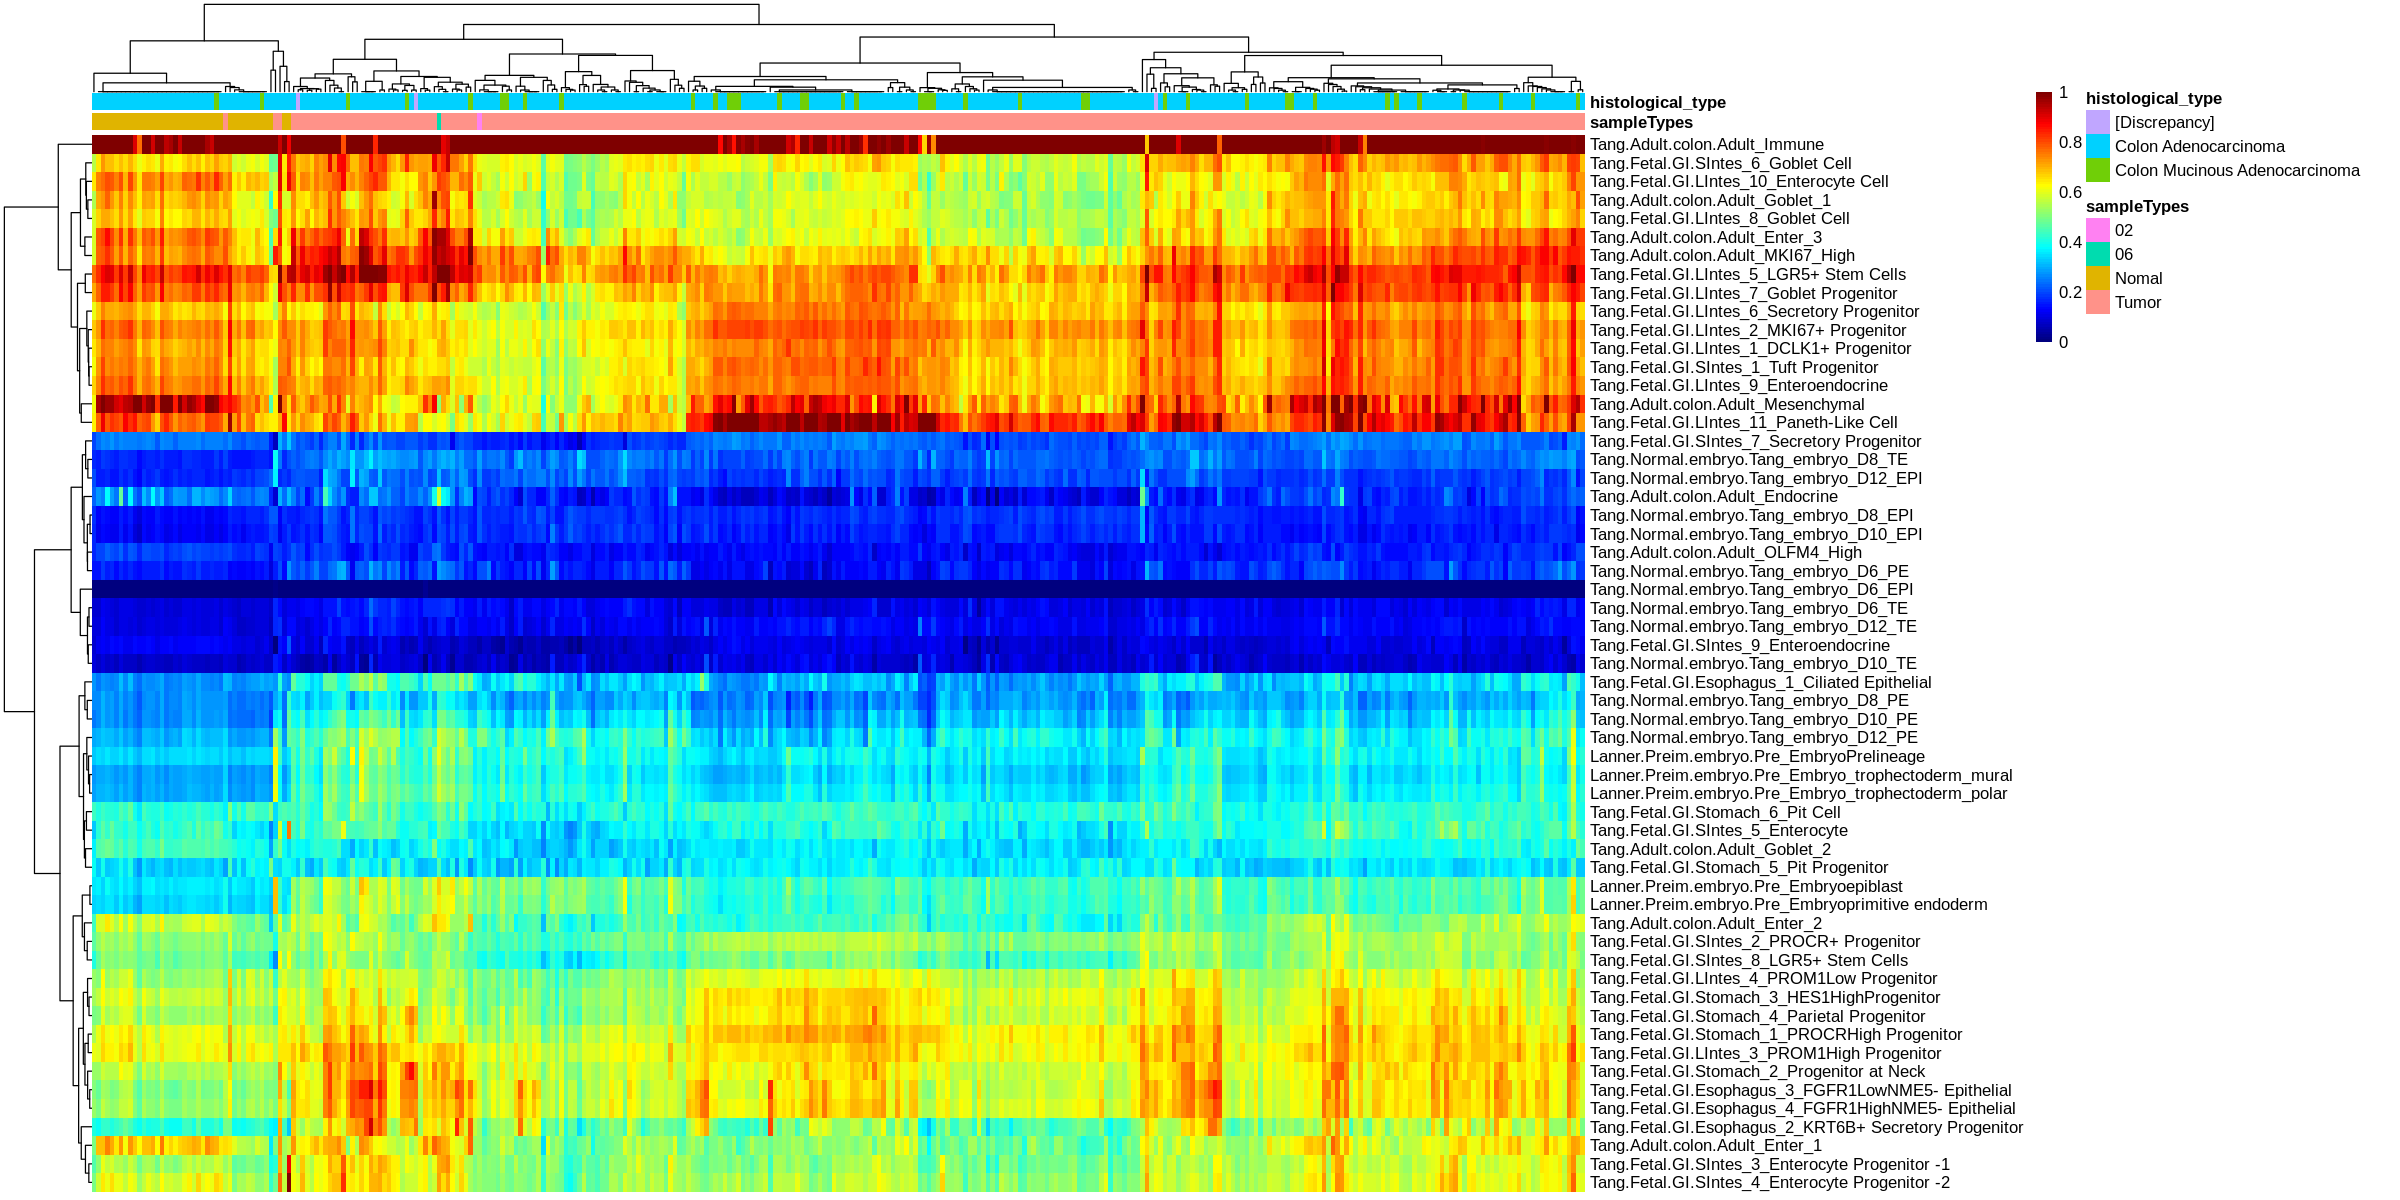

In [11]:
# cv1500 
source("/data8t_4/JH/MyJobs/1_R_script/NormalCancer/JH_SC3_cluster.R")
Cor.tumor <- Trans.Rang1.1500
Pheno.merged.tumor <- COAD.pheno[,c("sampleTypes","histological_type")]
### Step3.Cluster cells (In my script the cells with 0 variance was removed)
SC3.Tumor <- JH_SC3_cluster(Cor.tumor,Pheno.merged.tumor,ks=2:4)
## Select a cluster results
hcTumor <- SC3.Tumor$`3`$hc
## Check cluster result
source("/data8t_4/JH/MyJobs/1_R_script/R_Plot/heatmap.JH.R")
options(repr.plot.width=20, repr.plot.height=10)
heatmap.JH(Cor.tumor,show_colnames = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor)

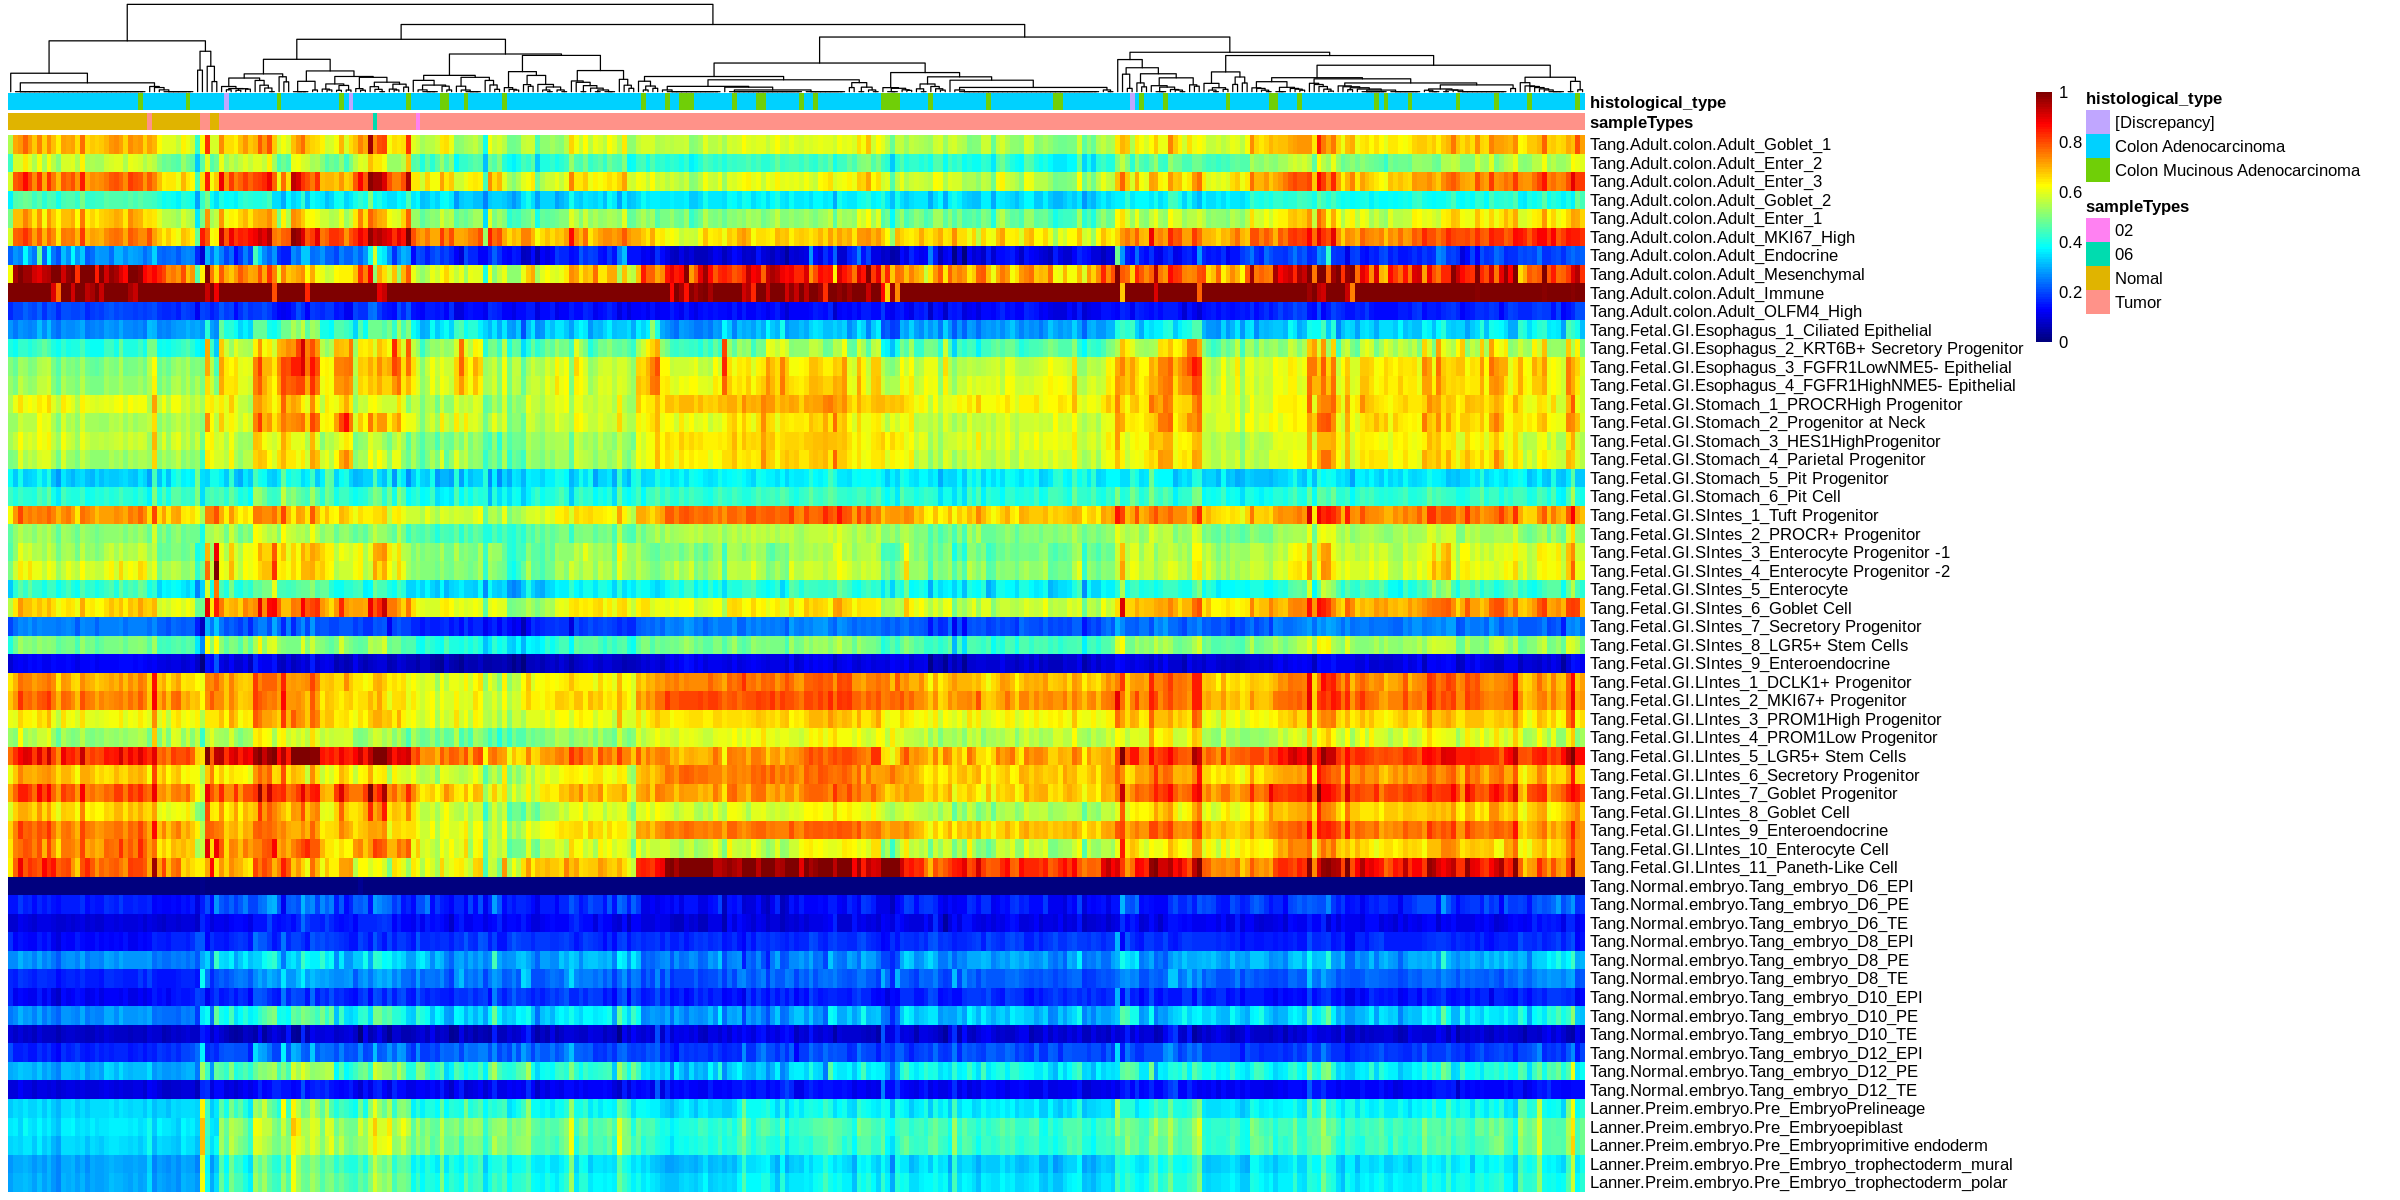

In [12]:
hcTumor.1500 <- hcTumor
heatmap.JH(Cor.tumor,show_colnames = F,cluster_rows = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor.1500)

Setting SC3 parameters...
Calculating distances between the cells...
Performing transformations and calculating eigenvectors...
Performing k-means clustering...


Calculating consensus matrix...


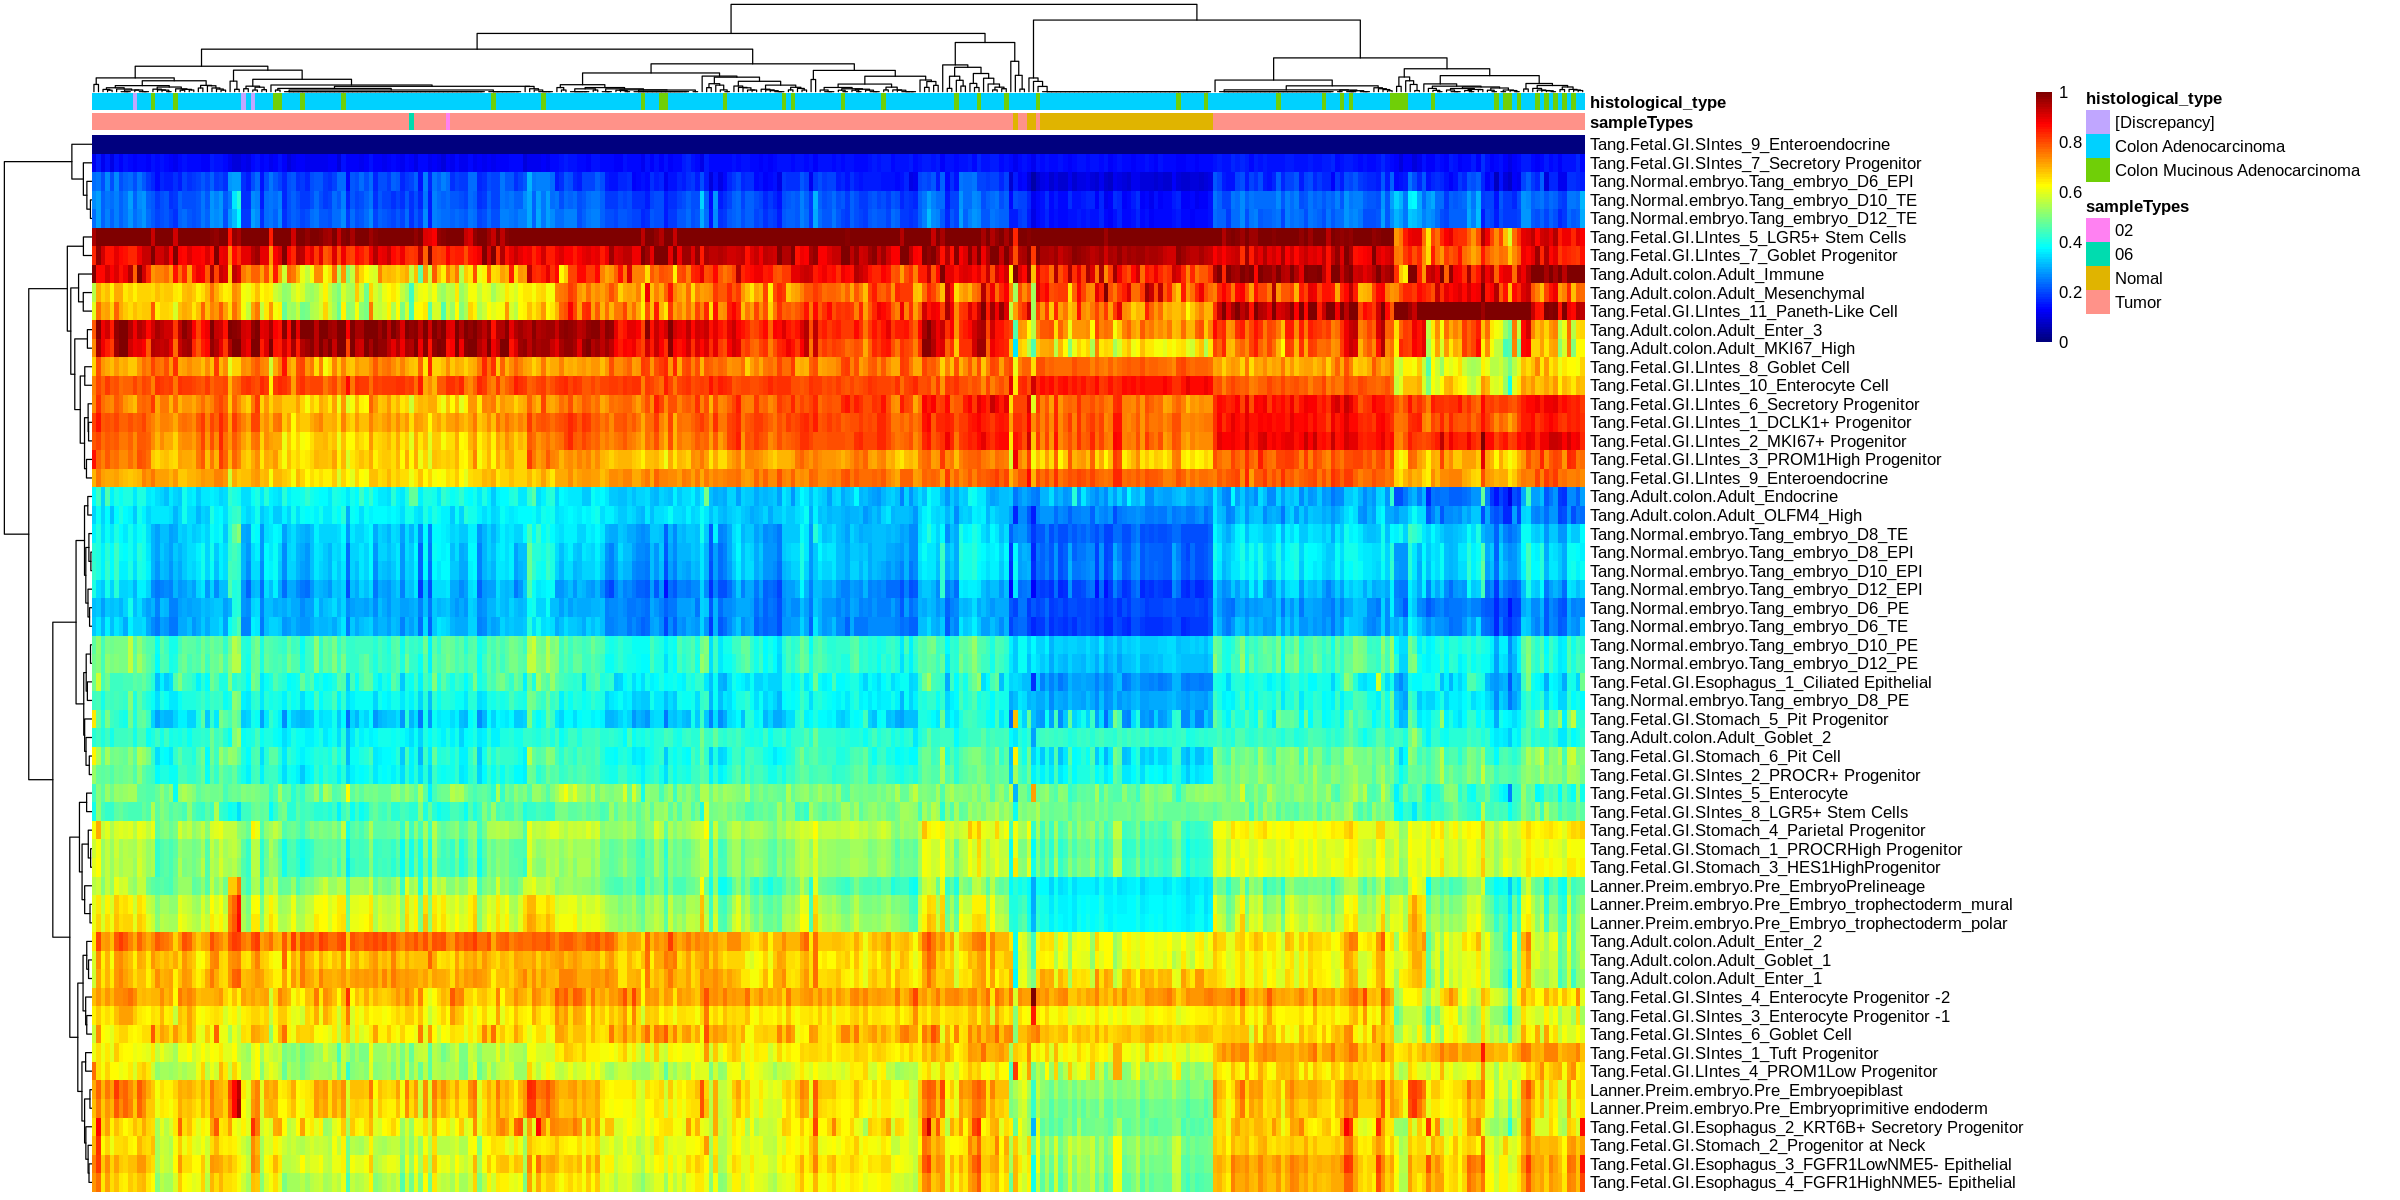

In [13]:
# cv1000 
source("/data8t_4/JH/MyJobs/1_R_script/NormalCancer/JH_SC3_cluster.R")
Cor.tumor <- Trans.Rang1.1000
Pheno.merged.tumor <- COAD.pheno[,c("sampleTypes","histological_type")]
### Step3.Cluster cells (In my script the cells with 0 variance was removed)
SC3.Tumor <- JH_SC3_cluster(Cor.tumor,Pheno.merged.tumor,ks=2:4)
## Select a cluster results
hcTumor <- SC3.Tumor$`3`$hc
## Check cluster result
source("/data8t_4/JH/MyJobs/1_R_script/R_Plot/heatmap.JH.R")
options(repr.plot.width=20, repr.plot.height=10)
heatmap.JH(Cor.tumor,show_colnames = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor)

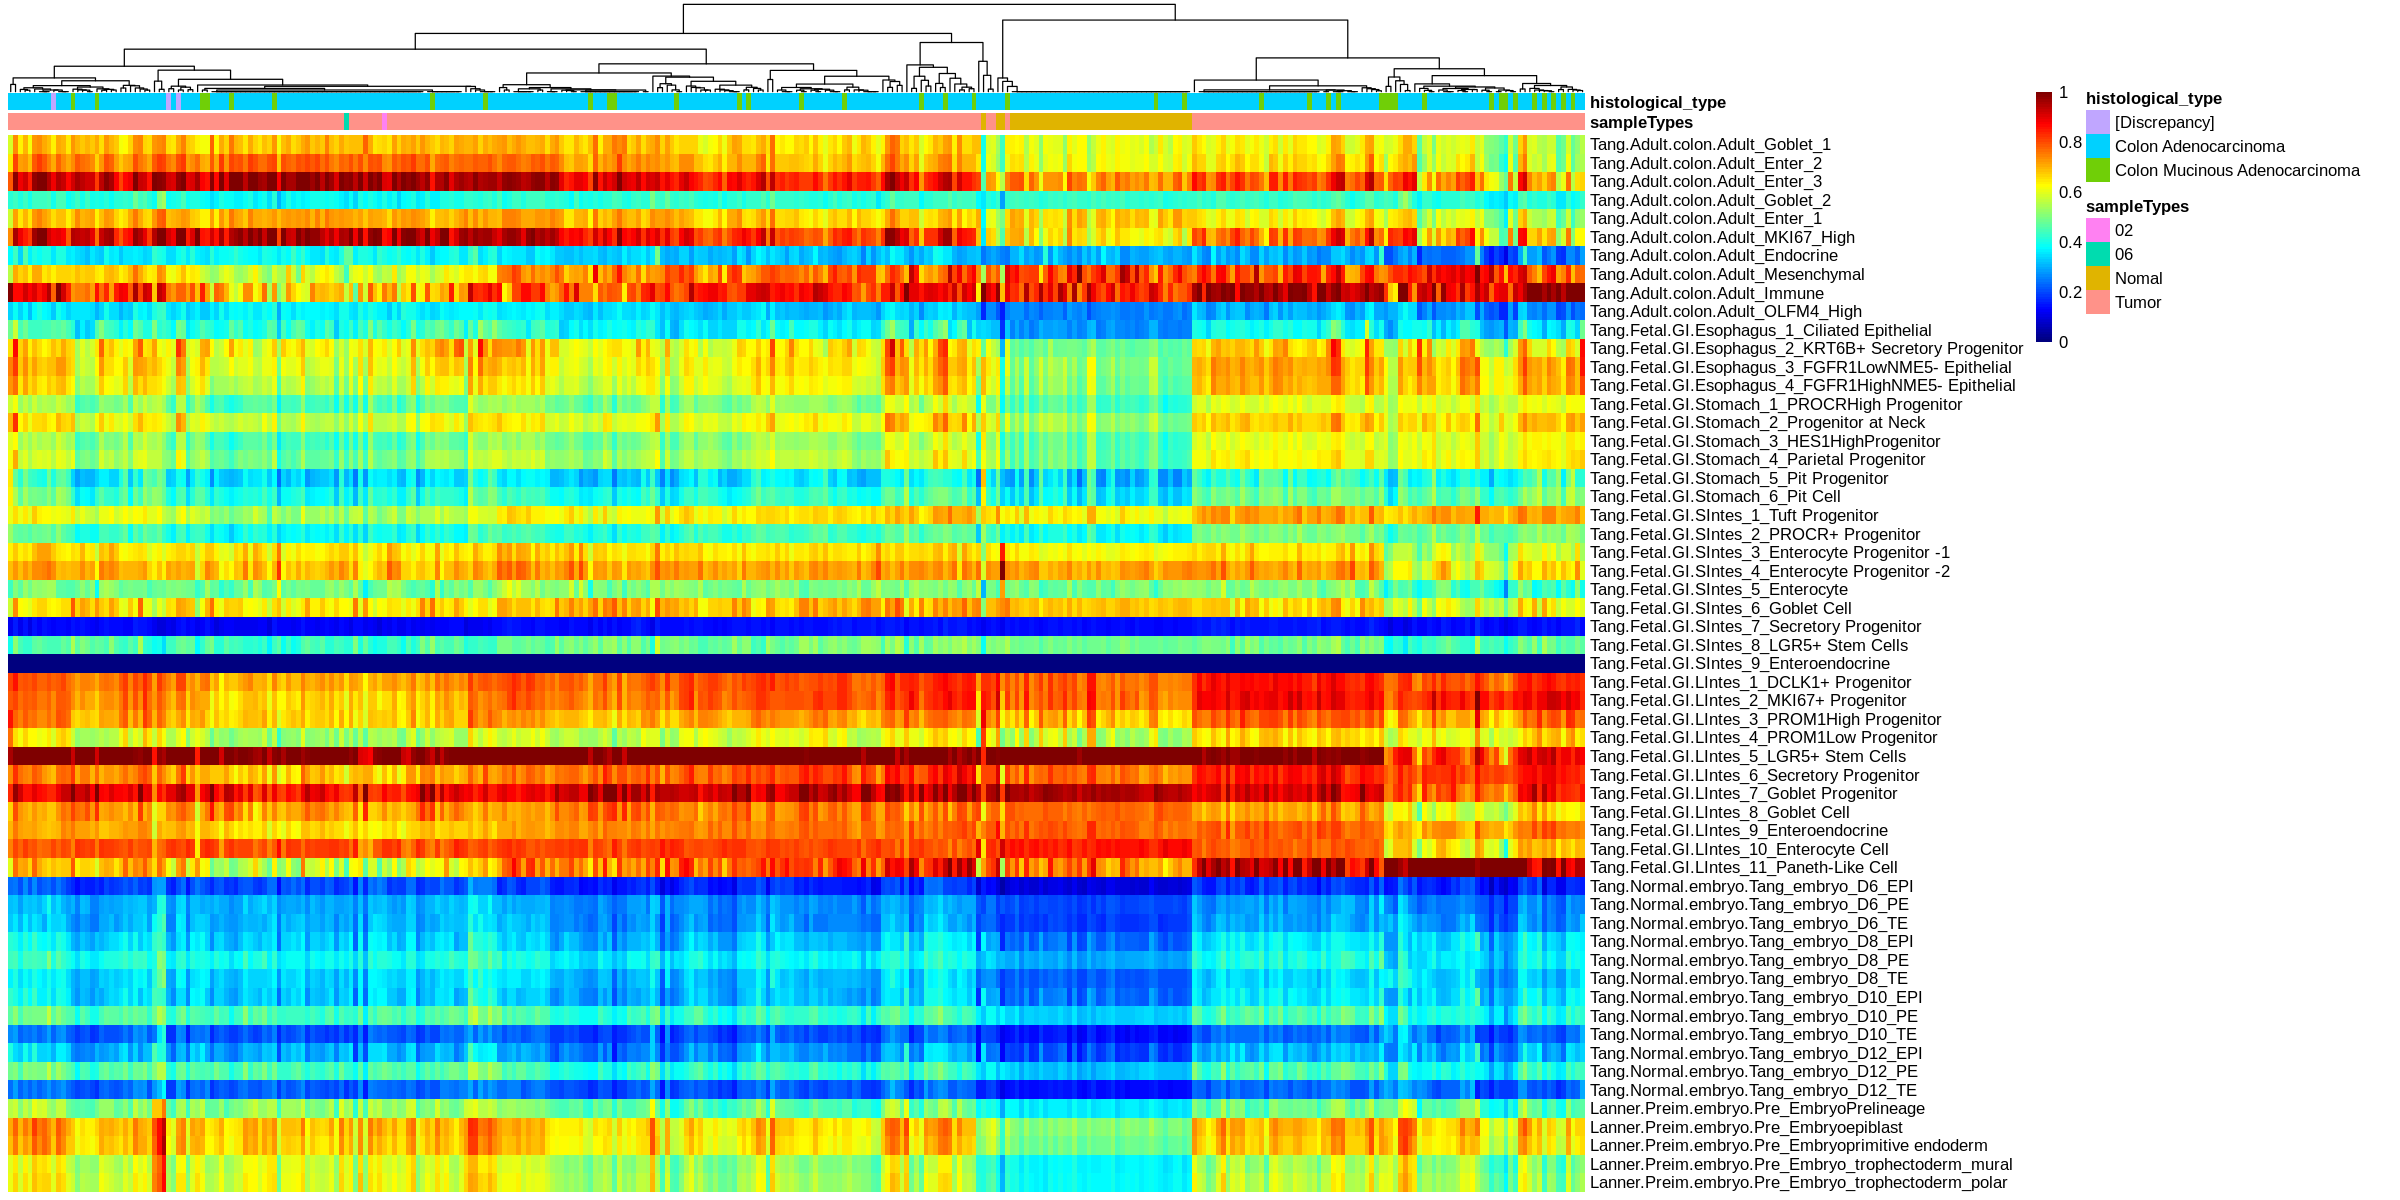

In [14]:
hcTumor.1000 <- hcTumor
heatmap.JH(Cor.tumor,show_colnames = F,cluster_rows = F,
           annotation_col = Pheno.merged.tumor, cluster_cols = hcTumor.1000)